In [0]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import Window
import numpy as np

In [0]:
path = '/mnt/datalake/tmp/amani/data_token/data_info_token2'
data = spark.read.parquet(path)

In [0]:
#recuper les données à partir la base de données
#data= sqlContext.table("token_db.info_token")
data=data.withColumn("Age_token_jour",col("Age_token")/24)
data=data.withColumn("Age_token_mois",col("Age_token_jour")/30)
data=data.withColumn("temps_inactivite_mois",col("temps_inactivite")/30)

In [0]:
#0 actif , 1 inactif 
data=data.withColumn("profil_utilisateur",when(col("temps_inactivite_mois")<5,0).otherwise(1))
#ajouter la colonne de confinement 
data=data.withColumn("confinement",
                                   when(((data.date_premiere_cap>="2020-03-17" )& (data.date_premiere_cap<="2020-05-10" ))
                                  |((data.date_premiere_cap>="2020-10-30" )& (data.date_premiere_cap<="2020-12-15" ))
                                  |((data.date_premiere_cap>="2021-04-03" )& (data.date_premiere_cap<="2021-05-03" )),True)
                                  .otherwise(False))

In [0]:
data=(data.withColumn("year",year("date_premiere_cap"))
         .withColumn("month",month("date_premiere_cap")))

In [0]:
data=data.withColumn("recrutement",
                                  when((data.date_premiere_cap.contains("2019-04"))
                                  |(data.date_premiere_cap.contains("2019-05"))
                                  |(data.date_premiere_cap.contains("2020-07"))
                                  |(data.date_premiere_cap.contains("2020-01"))
                                  |(data.date_premiere_cap.contains("2020-09"))
                                  |(data.date_premiere_cap.contains("2021-09"))
                                  |(data.date_premiere_cap.contains("2022-05"))
                                  |(data.date_premiere_cap.contains("2022-08"))
                                  |(data.date_premiere_cap.contains("2022-09"))
                                  |(data.date_premiere_cap.contains("2022-10")),1)
                                  .otherwise(0))



                                  
                                  

In [0]:
df=data.toPandas()
# Convert the date column to datetime
import pandas as pd 
df['date_premiere_cap'] = pd.to_datetime(df['date_premiere_cap'])

In [0]:
df["device_tend"] = df["nombre_device"].diff()
df['device_tendance'] = np.where(df["device_tend"]<0, 0, 1)

In [0]:
df=df.set_index("date_premiere_cap")
daily_data=df.resample('D').agg({'nombre_trajet':'sum',
                                          'nombre_device':'sum',
                                          'nombre_km':'sum',
                                          'temps_inactivite_max_entre_2trajets':'sum',
                                          'Age_token_mois':'sum',
                                          'temps_inactivite_mois':'sum',
                                          'token':'count',
                                          'profil_utilisateur':'sum',
                                           'confinement':'sum',
                                'device_tendance':'sum',
                                #"recrutement":"sum"
                                })

In [0]:
daily_data['confinement'] = np.where(daily_data['confinement']!=0, 1, 0)
daily_data['device_tendance'] = np.where(daily_data['device_tendance']!=0, 1, 0)
#daily_data['recrutement'] = np.where(daily_data['recrutement']!=0, 1, 0)

In [0]:
data_model=daily_data[["nombre_trajet","nombre_device","nombre_km","Age_token_mois","temps_inactivite_mois","profil_utilisateur",'device_tendance']]


In [0]:
def train_test_split(data):
    size=int(len(data)*0.7)
    train =data.iloc[0:size] 
    test = data.iloc[size:] 
    return train, test

In [0]:
train,test=train_test_split(data_model)

In [0]:
#train
X_arima_train=train.drop('profil_utilisateur',axis=1)
y_arima_train=train.profil_utilisateur
#test
X_arima_test=test.drop('profil_utilisateur',axis=1)
y_arima_test=test.profil_utilisateur

In [0]:
import pmdarima as pm
model = pm.auto_arima(y_arima_train, X_arima_train, 
                      max_p=5, max_q=5,
                      m=1,             
                      d=1, 
                      trace=True, 
                      error_action="ignore", suppress_warnings=True)
model.fit(y_arima_train,X_arima_train)
# model = pm.auto_arima(y_arima_train, X_arima_train,           max_p=5, max_q=5, m=6,
#                            start_P=0, seasonal=True,
#                            d=1, D=1, trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=True)
# model.fit(y_arima_train,X_arima_train)
 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept : AIC=560.989, Time=9.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept : AIC=895.795, Time=4.90 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept : AIC=606.822, Time=6.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept : AIC=537.264, Time=6.97 sec
 ARIMA(0,1,0)(0,0,0)[0] : AIC=7863.537, Time=4.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept : AIC=547.514, Time=7.81 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept : AIC=547.415, Time=8.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept : AIC=559.106, Time=7.91 sec
 ARIMA(0,1,1)(0,0,0)[0] : AIC=535.263, Time=6.74 sec
 ARIMA(1,1,1)(0,0,0)[0] : AIC=545.514, Time=7.15 sec
 ARIMA(0,1,2)(0,0,0)[0] : AIC=545.415, Time=8.12 sec
 ARIMA(1,1,0)(0,0,0)[0] : AIC=604.822, Time=6.65 sec
 ARIMA(1,1,2)(0,0,0)[0] : AIC=557.106, Time=7.40 sec

Best model: ARIMA(0,1,1)(0,0,0)[0] 
Total fit time: 98.321 seconds
Out[25]: ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
 with_intercept=False)

In [0]:
model.summary()

Out[26]:

SARIMAX Results 
 
 Dep. Variable: y No. Observations: 1153 
 
 
 Model: SARIMAX(0, 1, 1) Log Likelihood -259.632 
 
 
 Date: Tue, 06 Dec 2022 AIC 535.263 
 
 
 Time: 15:54:43 BIC 575.657 
 
 
 Sample: 05-27-2018 HQIC 550.510 
 
 
 - 07-22-2021 
 
 
 Covariance Type: opg 
 
 
 
 
 coef std err z P>|z| [0.025 0.975] 
 
 
 nombre_trajet -2.656e-07 3.29e-08 -8.063 0.000 -3.3e-07 -2.01e-07 
 
 
 nombre_device 0.4832 0.004 125.450 0.000 0.476 0.491 
 
 
 nombre_km 3.125e-06 5.64e-07 5.545 0.000 2.02e-06 4.23e-06 
 
 
 Age_token_mois -0.0132 0.000 -45.138 0.000 -0.014 -0.013 
 
 
 temps_inactivite_mois 0.0142 0.000 100.310 0.000 0.014 0.014 
 
 
 device_tendance 0.0508 0.032 1.591 0.112 -0.012 0.113 
 
 
 ma.L1 -0.5633 0.011 -52.417 0.000 -0.584 -0.542 
 
 
 sigma2 0.0957 0.001 73.350 0.000 0.093 0.098 
 
 
 
 
 Ljung-Box (L1) (Q): 7.78 Jarque-Bera (JB): 125474.70 
 
 
 Prob(Q): 0.01 Prob(JB): 0.00 
 
 
 Heteroskedasticity (H): 0.96 Skew: 2.28 
 
 
 Prob(H) (two-sided): 0.70 Kurtosis: 53.92 
 
 Warnings: [1] Covariance matrix calculated using the outer product of gradients (complex-step).

In [0]:
forecast_test = model.predict(len(X_arima_test),X_arima_test)
test["Forecast_ARIMAX"] = forecast_test

<command-568913936847293>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 test["Forecast_ARIMAX"] = forecast_test

In [0]:
forecast_train = model.predict(len(X_arima_train),X_arima_train)
train["Forecast_ARIMAX"] = forecast_train 

<command-568913936847294>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 train["Forecast_ARIMAX"] = forecast_train

Out[29]:

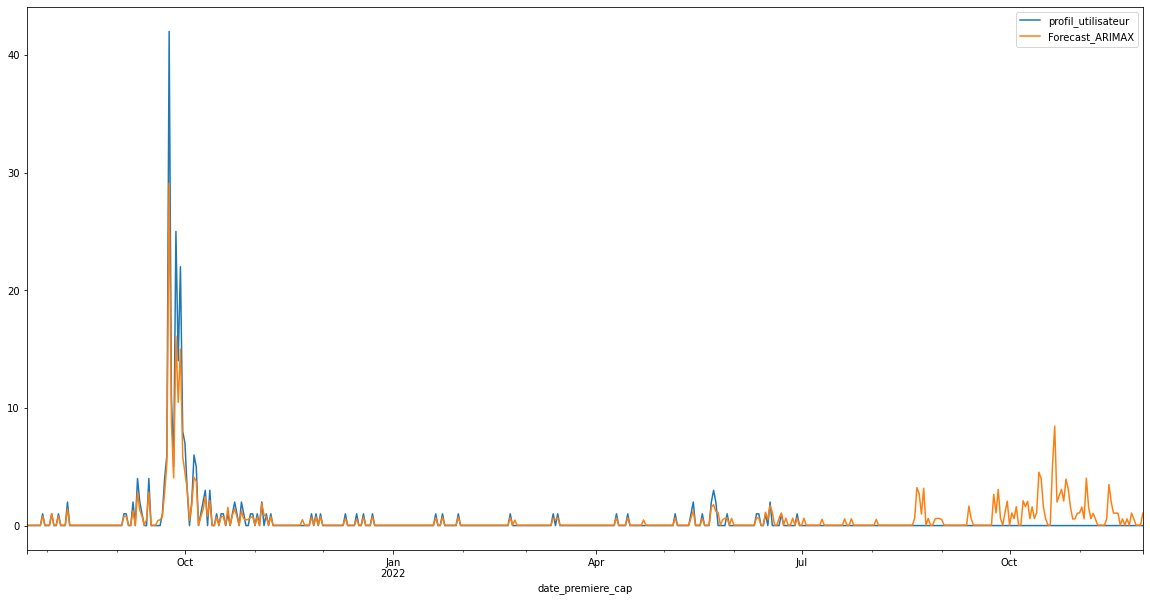

<AxesSubplot:xlabel='date_premiere_cap'>

In [0]:
test[["profil_utilisateur", "Forecast_ARIMAX"]].plot(figsize=(20, 10))

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

print("test score",r2_score(test.profil_utilisateur,(test.Forecast_ARIMAX)))
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(test.profil_utilisateur,(test.Forecast_ARIMAX))))

print("\nMAE of Auto ARIMAX:", mean_absolute_error(test.profil_utilisateur, test.Forecast_ARIMAX))

test score 0.8075675670375522
RMSE of Auto ARIMAX: 1.1634099577362293

MAE of Auto ARIMAX: 0.41558958190386275

Out[31]:

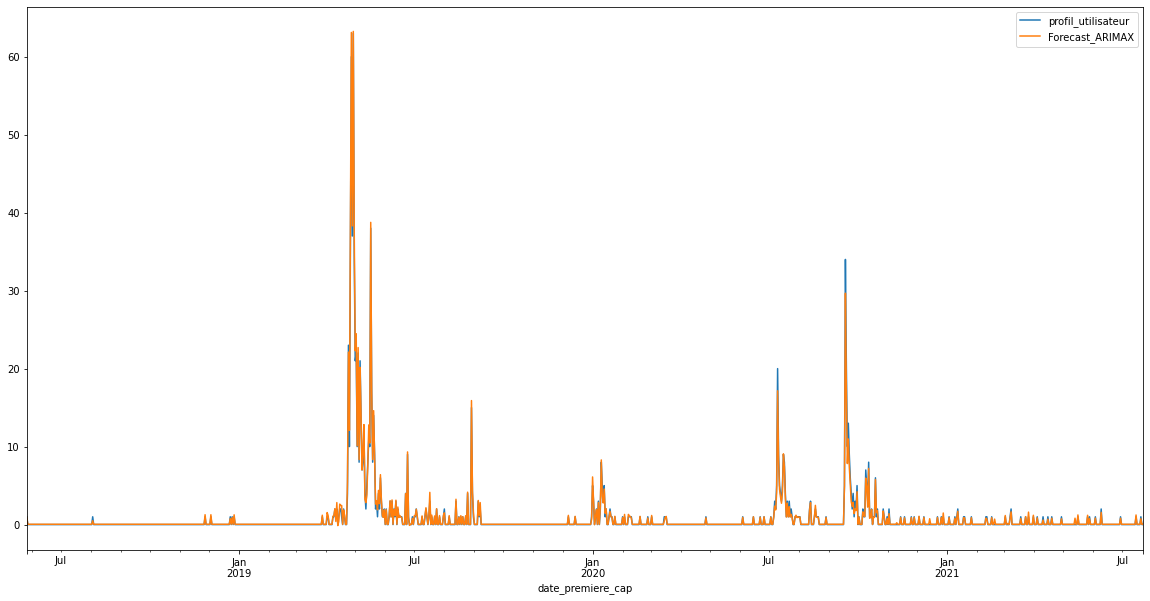

<AxesSubplot:xlabel='date_premiere_cap'>

In [0]:
train[["profil_utilisateur", "Forecast_ARIMAX"]].plot(figsize=(20, 10))

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("train score",r2_score(train.profil_utilisateur,(train.Forecast_ARIMAX)))

print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(train.profil_utilisateur,(train.Forecast_ARIMAX))))

print("\nMAE of Auto ARIMAX:", mean_absolute_error(train.profil_utilisateur, train.Forecast_ARIMAX))

train score 0.9930367991457204
RMSE of Auto ARIMAX: 0.345998944284552

MAE of Auto ARIMAX: 0.1218809143759327